# DrivenData Machine Learning with a Heart
Detect heart disease from patient cardiovascular dataset. The objective of this project is to predict the binary class, `heart_disease_present`, which represents whether or not a patient has heart disease:
- `0` represents no heart disease present
- `1` represents heart disease present

DrivenData [competition info here](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/107/); data provided by [Cleveland Heart Disease Database](http://archive.ics.uci.edu/ml/datasets/statlog+(heart)) via the UCI Machine Learning repository

- Invert values for `num_major_vessels` (0-3) values should change to (3-0) ie 1 changes to 2, 0, changes to 3
- Invert values for `ST_depression` - values represent where ST segment is abnormally low below baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, KBinsDiscretizer

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_values.csv')
labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/train_labels.csv')
labels.drop(['patient_id'],axis=1,inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [4]:
X_train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
117,9dqkpy,1,reversible_defect,110,4,0,0,2,172,0.0,1,41,158,0
65,nck22c,1,reversible_defect,126,4,0,0,2,282,0.0,1,35,156,1
67,f70grj,2,normal,115,4,0,0,0,303,1.2,1,43,181,0
31,z7xkou,2,reversible_defect,150,4,3,0,2,225,1.0,0,65,114,0
12,mpggsq,1,normal,140,3,0,0,0,335,0.0,1,64,158,0


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 14 columns):
patient_id                              144 non-null object
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null object
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null int64
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 16.9+ KB

In [6]:
X_train.drop(['patient_id'],axis=1,inplace=True)

/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
X_train.loc[:,'thal'] = X_train.loc[:,'thal'].astype('category')

/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
X_train.loc[:,'chest_pain_type'] = X_train.loc[:,'chest_pain_type'].astype('category')

In [9]:
X_train['thal'].value_counts()

normal               79
reversible_defect    58
fixed_defect          7
Name: thal, dtype: int64

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null category
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null category
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: category(2), float64(1), int64(10)
memory usage: 14.1 KB


In [11]:
#X_train = pd.get_dummies(X_train)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 117 to 102
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       144 non-null int64
thal                                    144 non-null category
resting_blood_pressure                  144 non-null int64
chest_pain_type                         144 non-null category
num_major_vessels                       144 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    144 non-null int64
resting_ekg_results                     144 non-null int64
serum_cholesterol_mg_per_dl             144 non-null int64
oldpeak_eq_st_depression                144 non-null float64
sex                                     144 non-null int64
age                                     144 non-null int64
max_heart_rate_achieved                 144 non-null int64
exercise_induced_angina                 144 non-null int64
dtypes: category(2), float64(1), int64(10)
memory usage: 14.1 KB


In [13]:
X_train.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.527778,131.472222,0.694444,0.166667,1.006944,246.409722,0.960417,0.673611,55.020833,149.694444,0.326389
std,0.636253,17.078160,0.977207,0.373979,0.999976,47.140827,1.109981,0.470528,9.004637,22.091443,0.470528
min,1.000000,94.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,34.000000,96.000000,0.000000
25%,1.000000,120.000000,0.000000,0.000000,0.000000,212.750000,0.000000,0.000000,48.750000,136.250000,0.000000
50%,1.000000,130.000000,0.000000,0.000000,1.500000,245.500000,0.600000,1.000000,56.000000,152.500000,0.000000
75%,2.000000,140.000000,1.000000,0.000000,2.000000,277.000000,1.525000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,3.000000,1.000000,2.000000,417.000000,6.200000,1.000000,77.000000,192.000000,1.000000


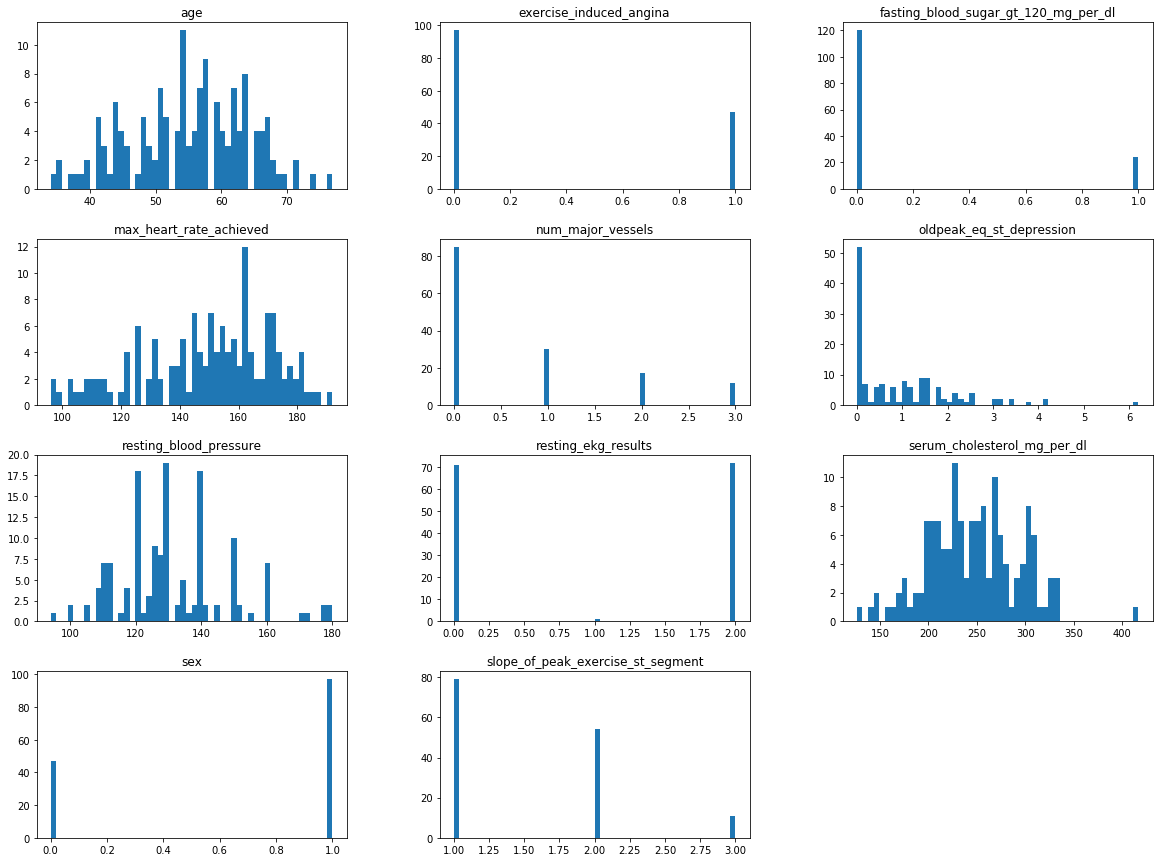

In [14]:
X_train.hist(bins=50, figsize=(20,15),grid=False)
plt.show()

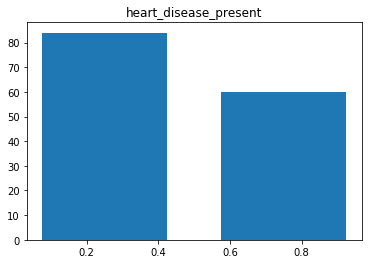

In [15]:
y_train.hist(bins=2,rwidth=.7,grid=False)
plt.show()

In [18]:
def get_cat_num_labels(df):
    num = []
    cat = []
    for col in df.columns:
        if df[col].dtype == 'float64':
            num.append(col)
        elif df[col].dtype == 'int64':
            num.append(col)
        else:
            cat.append(col)
    return num, cat

In [19]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [20]:
num, cat = get_cat_num_labels(X_train)

In [21]:
num

['slope_of_peak_exercise_st_segment',
 'resting_blood_pressure',
 'num_major_vessels',
 'fasting_blood_sugar_gt_120_mg_per_dl',
 'resting_ekg_results',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'sex',
 'age',
 'max_heart_rate_achieved',
 'exercise_induced_angina']

In [22]:
cat

['thal', 'chest_pain_type']

In [47]:
num_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(num)),
    ('Normalizer', MinMaxScaler(feature_range=(0,1))),
])

cat_pipeline = Pipeline([
    ('df_selector',DataFrameSelector(cat)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),
                ])

poly2_pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),
    ('poly',PolynomialFeatures(2)),
                ])

poly3_pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),
    ('poly',PolynomialFeatures(3)),
                ])

poly4_pipe = Pipeline([('feats',FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline',cat_pipeline),
])),
    ('poly',PolynomialFeatures(4)),
                ])

In [24]:
corr_matrix = X_train.corr()

In [25]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
slope_of_peak_exercise_st_segment,1,0.1,0.07,0.069,0.16,-0.039,0.59,0.089,0.19,-0.42,0.21
resting_blood_pressure,0.1,1,0.033,0.13,0.029,0.19,0.25,-0.091,0.22,-0.054,0.1
num_major_vessels,0.07,0.033,1,0.18,0.095,0.13,0.22,0.071,0.34,-0.29,0.2
fasting_blood_sugar_gt_120_mg_per_dl,0.069,0.13,0.18,1,-0.0031,0.014,0.0042,0.11,0.097,0.076,0.0066
resting_ekg_results,0.16,0.029,0.095,-0.0031,1,0.16,0.14,0.094,0.086,-0.12,0.084
serum_cholesterol_mg_per_dl,-0.039,0.19,0.13,0.014,0.16,1,-0.035,-0.12,0.19,-0.14,0.16
oldpeak_eq_st_depression,0.59,0.25,0.22,0.0042,0.14,-0.035,1,0.059,0.23,-0.32,0.19
sex,0.089,-0.091,0.071,0.11,0.094,-0.12,0.059,1,-0.14,-0.031,0.23
age,0.19,0.22,0.34,0.097,0.086,0.19,0.23,-0.14,1,-0.43,0.11
max_heart_rate_achieved,-0.42,-0.054,-0.29,0.076,-0.12,-0.14,-0.32,-0.031,-0.43,1,-0.39


In [26]:
y_train = y_train['heart_disease_present'].values

In [39]:
X_train1 = pipe.fit_transform(X_train)

In [35]:
X_train2 = poly2_pipe.fit_transform(X_train)

In [36]:
X_train3 = poly3_pipe.fit_transform(X_train)

In [48]:
X_train4 = poly4_pipe.fit_transform(X_train)

### Model Evaluation

In [28]:
model_dict = {
    'SGD':SGDClassifier(max_iter=1000,tol=0.001,random_state=42),
    'Logistic Regression':LogisticRegression(solver='lbfgs',random_state=42),
    'Decision Tree':DecisionTreeClassifier(random_state=42),
    'SVC':SVC(gamma='auto',random_state=42),
    'SVC Poly':SVC(kernel='poly',gamma='auto',random_state=42),
    'KNN':KNeighborsClassifier(),
    'Forest':RandomForestClassifier(n_estimators=100,random_state=42),
    'Extra Trees':ExtraTreesClassifier(n_estimators=1000,random_state=42),
    'Adaboost':AdaBoostClassifier(random_state=42),
    'XGBoost':XGBClassifier()
}

In [30]:
def model_eval(X, y, model_dict=model_dict, cv=5, scoring="roc_auc"):
    scores_df = pd.DataFrame()
    for model in model_dict:
        cvs = cross_val_score(model_dict[model], X, y, cv=cv, scoring=scoring)
        scores_df[model] = cvs
    return scores_df

In [40]:
scores_df = model_eval(X_train1, y_train)
scores_df.describe()[1:]

,SGD,Logistic Regression,Decision Tree,SVC,SVC Poly,KNN,Forest,Extra Trees,Adaboost,XGBoost
mean,0.863848,0.890441,0.740564,0.882598,0.889583,0.832659,0.891176,0.878125,0.829902,0.865257
std,0.068189,0.035344,0.047383,0.037776,0.039522,0.042271,0.044477,0.032545,0.136086,0.069303
min,0.750000,0.848039,0.693627,0.852941,0.848039,0.786765,0.848039,0.850490,0.598039,0.789216
25%,0.862745,0.867647,0.708333,0.857843,0.857843,0.813725,0.855392,0.857843,0.857843,0.808824
50%,0.877451,0.887255,0.739583,0.857843,0.897059,0.830882,0.887255,0.867647,0.857843,0.882353
75%,0.901961,0.911765,0.745098,0.906863,0.897059,0.830882,0.906863,0.882353,0.877451,0.882353
max,0.927083,0.937500,0.816176,0.937500,0.947917,0.901042,0.958333,0.932292,0.958333,0.963542


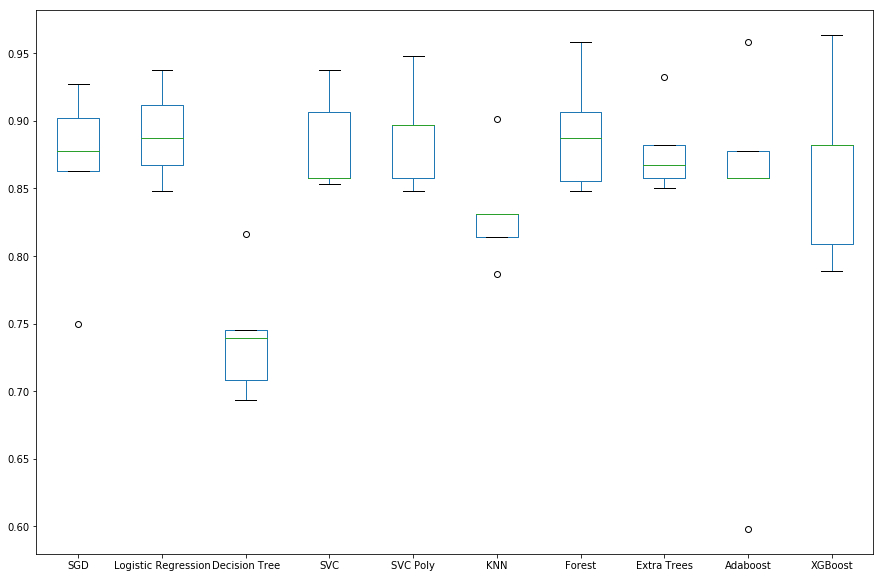

In [41]:
scores_df.plot(kind='box', figsize=(15,10))

In [42]:
scores_df2 = model_eval(X_train2, y_train)
scores_df2.describe()[1:]

,SGD,Logistic Regression,Decision Tree,SVC,SVC Poly,KNN,Forest,Extra Trees,Adaboost,XGBoost
mean,0.846017,0.865686,0.696569,0.882659,0.886581,0.821936,0.890625,0.882598,0.792157,0.848284
std,0.020456,0.036122,0.058475,0.039336,0.040562,0.052424,0.039952,0.032474,0.089627,0.074465
min,0.823529,0.828431,0.644608,0.848039,0.838235,0.769608,0.850490,0.862745,0.676471,0.745098
25%,0.828125,0.833333,0.644608,0.857843,0.857843,0.789216,0.862745,0.862745,0.745098,0.813725
50%,0.848039,0.872549,0.698529,0.862745,0.892157,0.816176,0.887255,0.862745,0.799020,0.848039
75%,0.857843,0.877451,0.708333,0.901961,0.901961,0.828431,0.899510,0.887255,0.823529,0.897059
max,0.872549,0.916667,0.786765,0.942708,0.942708,0.906250,0.953125,0.937500,0.916667,0.937500


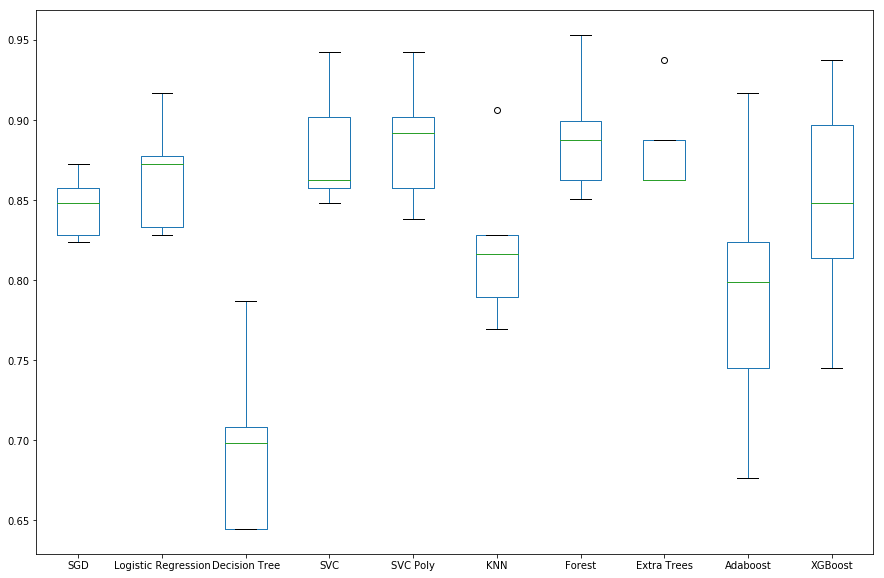

In [44]:
scores_df2.plot(kind='box', figsize=(15,10))

In [45]:
scores_df3 = model_eval(X_train3, y_train)
scores_df3.describe()[1:]

,SGD,Logistic Regression,Decision Tree,SVC,SVC Poly,KNN,Forest,Extra Trees,Adaboost,XGBoost
mean,0.852451,0.859620,0.727206,0.889645,0.870895,0.820466,0.880821,0.886520,0.837071,0.842341
std,0.052864,0.034835,0.111181,0.039397,0.064021,0.037608,0.047995,0.030608,0.045846,0.069569
min,0.784314,0.818627,0.593137,0.857843,0.784314,0.774510,0.833333,0.862745,0.779412,0.750000
25%,0.818627,0.833333,0.661765,0.862745,0.828431,0.789216,0.840686,0.867647,0.813725,0.803922
50%,0.862745,0.857843,0.698529,0.872549,0.887255,0.830882,0.887255,0.872549,0.833333,0.848039
75%,0.875000,0.887255,0.828431,0.901961,0.911765,0.843137,0.889706,0.892157,0.857843,0.877451
max,0.921569,0.901042,0.854167,0.953125,0.942708,0.864583,0.953125,0.937500,0.901042,0.932292


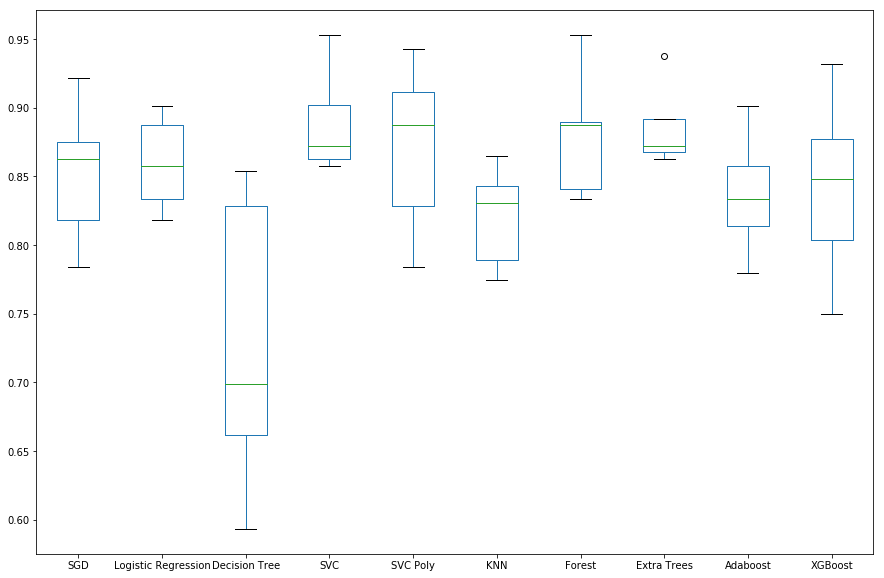

In [46]:
scores_df3.plot(kind='box', figsize=(15,10))

In [49]:
scores_df4 = model_eval(X_train4, y_train)
scores_df4.describe()[1:]

,SGD,Logistic Regression,Decision Tree,SVC,SVC Poly,KNN,Forest,Extra Trees,Adaboost,XGBoost
mean,0.825919,0.854779,0.728186,0.886703,0.869914,0.828064,0.885110,0.881556,0.789583,0.855208
std,0.047400,0.041491,0.094714,0.043879,0.068994,0.060893,0.037594,0.032205,0.101097,0.078442
min,0.784314,0.803922,0.610294,0.843137,0.774510,0.779412,0.840686,0.852941,0.622549,0.730392
25%,0.786458,0.833333,0.661765,0.852941,0.823529,0.789216,0.867647,0.857843,0.779412,0.843137
50%,0.808824,0.843137,0.757353,0.882353,0.897059,0.799020,0.882353,0.872549,0.808824,0.877451
75%,0.857843,0.887255,0.757353,0.901961,0.911765,0.845588,0.892157,0.892157,0.864583,0.882353
max,0.892157,0.906250,0.854167,0.953125,0.942708,0.927083,0.942708,0.932292,0.872549,0.942708


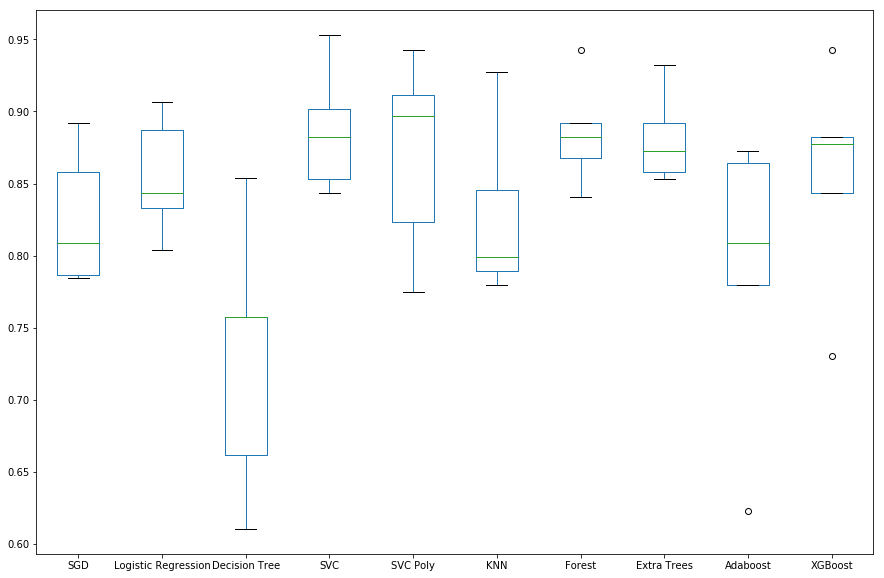

In [50]:
scores_df4.plot(kind='box', figsize=(15,10))

### Hyperparameter Tuning

#### XGBoost

In [ ]:
param_grid = [
    {'max_depth':[3,6,10,15],
     'n_estimators':[10,100,500,1000],
     'gamma':[0,0.5,1]
    }
]

In [ ]:
grid_search = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search.fit(X_train2, y_train)

In [ ]:
cvres = grid_search.cv_results_

In [ ]:
cvres = grid_search.cv_results_
cv_results = sorted([(x,y) for x,y in zip(cvres["mean_test_score"],cvres["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results:
    print(round(AUC,5), params)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

#### Extra Trees

In [ ]:
param_grid = [
    {'max_depth':[2,3],
     'n_estimators':[200,225,250,500,1000,1500],
     'bootstrap':[True,False],
    }
]

In [ ]:
grid_search_xtr = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), param_grid, cv=5, scoring="roc_auc")
grid_search_xtr.fit(X_train2, y_train)

In [ ]:
grid_search_xtr.best_score_

In [ ]:
cvres_xtr = grid_search_xtr.cv_results_
cv_results_xtr = sorted([(x,y) for x,y in zip(cvres_xtr["mean_test_score"],cvres_xtr["params"])],key=lambda x: x[0],reverse=True)
for AUC, params in cv_results_xtr:
    print(round(AUC,5), params)

In [ ]:
final_model = grid_search_xtr.best_estimator_

### Generate predictions on test_values dataset

In [ ]:
test_values = pd.read_csv('https://s3.amazonaws.com/drivendata/data/54/public/test_values.csv')

In [ ]:
test_values.info()

In [ ]:
test_values.loc[:,'thal'] = test_values.loc[:,'thal'].astype('category')
test_values.loc[:,'chest_pain_type'] = test_values.loc[:,'chest_pain_type'].astype('category')

In [ ]:
test_ids = test_values['patient_id']
test_values = test_values.drop('patient_id',axis=1)

In [ ]:
test_values.info()

In [ ]:
input_ = pipe.transform(test_values)
input_.shape

In [ ]:
test_values.shape

In [ ]:
X_train.shape

In [ ]:
X_train2.shape

In [ ]:
final_model.predict(input_)

In [ ]:
test_probas = final_model.predict_proba(input_)

In [ ]:
test_probas

In [ ]:
heart_disease_probas = [y for x,y in test_probas]

In [ ]:
out_df = pd.DataFrame({'patient_id':test_ids,'heart_disease_present':heart_disease_probas})
out_df

In [ ]:
out_df.to_csv('submission3.csv',index=False)